# OECD data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span><ul class="toc-item"><li><span><a href="#SSL-issues" data-toc-modified-id="SSL-issues-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SSL issues</a></span></li></ul></li><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Watermark</a></span></li></ul></li><li><span><a href="#OECD-inflation-data" data-toc-modified-id="OECD-inflation-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OECD inflation data</a></span><ul class="toc-item"><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Headline-inflation---selected-nations" data-toc-modified-id="Headline-inflation---selected-nations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Headline inflation - selected nations</a></span></li><li><span><a href="#Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)" data-toc-modified-id="Annualised-and-quarterly-smoothed-(using-seasonally-adjusted-series)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Annualised and quarterly smoothed (using seasonally adjusted series)</a></span></li><li><span><a href="#Latest-CPI-components" data-toc-modified-id="Latest-CPI-components-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Latest CPI components</a></span></li></ul></li></ul></div>

## Notes

### SSL issues

From January 2023 I got the error message: SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED. 
I gather the immediate issue is changes to the openSSL library. But the more significant issue is with the OECD website.

To fix this issue, I:

* created a text file named ~/ssl.conf with the following content:

        openssl_conf = openssl_init
    
        [openssl_init]
        ssl_conf = ssl_sect
    
        [ssl_sect]
        system_default = system_default_sect

        [system_default_sect]
        Options = UnsafeLegacyRenegotiation

* added this line to my .zshrc file (because I use zsh as my shell): 

        export OPENSSL_CONF=~/ssl.conf

## Python setup

### Imports

In [1]:
# analytic imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandasdmx import Request
from requests.exceptions import HTTPError

# system imports
from pathlib import Path
from datetime import date

# local imports
from finalise_plot import finalise_plot

### Settings

In [2]:
# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use('fivethirtyeight')

# multi-time-period charts
TODAY = pd.Timestamp('today')
RECENCY_PERIOD = 5 # years
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD)
MONTH_ADJ = 2 # months
RECENT = RECENT - pd.DateOffset(months=MONTH_ADJ)

# Other
SOURCE = "Source: OECD"

# Where to put the charts
CHART_DIR = "./charts/OECD"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)


### Watermark

In [3]:
%reload_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Jan 11 2023 17:58:05

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

seaborn   : 0.12.2
pandas    : 1.5.2
matplotlib: 3.6.2

Watermark: 2.3.1



## OECD inflation data

### Supporting functions

In [4]:
def build_key(locations, subject, measure, frequency, start):
    key = [locations, subject, measure, frequency]
    key_string = (
        f"{'.'.join(['+'.join(x) for x in key])}"
        f"/all?startTime={start}"
    )
    return key_string

In [5]:
# get the raw index data
def get_oecd_data(resource_id, key_string):
    oecd = Request('OECD')

    try:
        data = oecd.data(
            resource_id=resource_id,
            key=key_string,
        ).to_pandas()
    except HTTPError as err:
        data = pd.DataFrame()
          
    return data

In [6]:
# reframe the data from an index to growth
def reframe_as_growth(raw, periods, smooth, annualised):
    growth = (
        raw
        .unstack().T
        .pct_change(periods)
        .dropna(axis=0, how='all')
        .droplevel(axis=1, level=[1, 2, 3])
        * 100
    )
    if annualised:
        growth = growth * annualised
    if smooth:
        growth = growth.rolling(smooth).mean()
    return growth

In [7]:
def get_combine(locations, instructions):
    loc = locations.copy()
    gotten = pd.DataFrame()
    series = []
    
    for instruction in instructions:
        # get instructions
        (subject, measure, frequency, start,
         gperiods, smoothing, annualised) = instruction
        series.append(f'{subject}/{measure}/{frequency}')
        
        # capture CPI and transform to CPI growth
        key = build_key(loc, [subject], [measure], [frequency], start)
        raw_data = get_oecd_data(resource_id='PRICES_CPI', key_string=key)
        if not len(raw_data):
            continue
        data = reframe_as_growth(raw_data, gperiods, smoothing, annualised)
        data.index = pd.PeriodIndex(data.index, freq=frequency)
        data.index = data.index.to_timestamp(how='end')
        data.index = [pd.Timestamp(x.date()) for x in data.index]
        
        # remember
        gotten[data.columns] = data
        
        # prepare for next round
        loc = [x for x in loc if x not in data.columns]
        if not loc:   ### UNTESTED
            break     ### UNTESTED

    if loc:
        print(f'Check: did not capture {loc}')
        
    final = (
        gotten
        .interpolate(method='time', limit_area='inside')
        .sort_index(axis=1)
    )

    return series, final

### Headline inflation - selected nations

In [8]:
location_map = {
    'AUS':	'Australia',
    'AUT':	'Austria',
    'BEL':	'Belgium',
    'CAN':	'Canada',
    'CHL':	'Chile',
    'CZE':	'Czech Rep.',
    'DNK':	'Denmark',
    'EST':	'Estonia',
    'FIN':	'Finland',
    'FRA':	'France',
    'DEU':	'Germany',
    'GRC':	'Greece',
    'HUN':	'Hungary',
    'ISL':	'Iceland',
    'IRL':	'Ireland',
    'ISR':	'Israel',
    'ITA':	'Italy',
    'JPN':	'Japan', # missing most recent data
    'KOR':	'Korea',
    'LVA':	'Latvia',
    'LUX':	'Luxembourg',
    'MEX':	'Mexico',
    'NLD':	'Netherlands',
    'NZL':	'New Zealand',
    'NOR':	'Norway',
    'POL':	'Poland',
    'PRT':	'Portugal',
    'SVK':	'Slovak Rep.',
    'SVN':	'Slovenia',
    'ESP':	'Spain',
    'SWE':	'Sweden',
    'CHE':	'Switzerland',
    'TUR':	'Turkey', # Turkey 2022-11	84.389283	102.549467	123.340616
    'GBR':	'United Kingdom',
    'USA':	'United States',
    'ARG':	'Argentina',
    'BRA':	'Brazil',
    'CHN':	'China (PRC)',
    'COL':	'Colombia',
    'CRI':	'Costa Rica', # data issues
    'IND':	'India',
    'IDN':	'Indonesia',
    'LTU':	'Lithuania',
    'RUS':	'Russia',
    'SAU':	'Saudi Arabia',
    'ZAF':	'South Africa',
}

In [9]:
chart_sets = {
    # Limit charts to 6 nations - otherwise they are too cluttered
    'of_interest': ['AUS', 'USA', 'CAN', 'DEU', 'GBR', 'JPN', ],
    'anglosphere': ['AUS', 'USA', 'CAN', 'NZL', 'GBR', 'IRL', ],
    'major_europe': ['FRA', 'DEU', 'ITA', 'GBR', 'RUS', 'ESP', ],
    'largest_economies': ['USA', 'CHN', 'JPN', 'DEU', 'GBR', 'IND', ],
    
    'asia': ['KOR', 'JPN', 'CHN', 'IND', 'IDN', ],
    'north_europe': ['DNK', 'SWE', 'NOR', 'ISL', 'FIN', 'GBR', ],
    'baltic_europe': ['LVA', 'LTU', 'EST', ],
    'central_europe': ['CZE', 'HUN', 'SVK', 'SVN', 'POL', ],
    'west_europe': ['ESP', 'PRT', 'NLD', 'LUX', 'FRA', 'BEL', ],
    'germanic_europe': ['DEU', 'AUT', 'CHE', ],
    'se_europe': ['ITA', 'GRC', ],
    'turkey': ['TUR', ], # high inflation outlier.
   
    'n_america': ['USA', 'CAN', 'MEX', ],
    'c_s_america': ['CHL', 'ARG', 'BRA', 'COL', 'CRI', ],

    'other': ['AUS', 'NZL', 'SAU', 'ZAF', 'ISR', ],
}

In [10]:
measure, start = 'IXOB', '1969',    
instructions = [
    # subject, measure, frequency, start, gperiods, smoothing, annualised
    ['CP18ALTT', measure, 'M', start, 12, 0, 0], 
    ['CPALTT01', measure, 'M', start, 12, 0, 0],
    ['CPALTT01', measure, 'Q', start, 4,  0, 0],
]

title = 'CPI Growth - compared with same period in previous year'

for label, locations in chart_sets.items(): 
    print(label)
    
    # get the data
    oecd_series, headline = get_combine(locations, instructions)
    headline = headline.rename(location_map, axis=1)

    # plot the data
    for start in None, RECENT:
        data = (
            headline if start is None 
            else headline[headline.index >= start]
        )
        ax = data.plot(lw=2.5)
        ax.legend(title=None, loc='best', ncol=2)
        tag = label if start is None else f'{label}-recent'

        finalise_plot(
            ax, title, 
            'Per cent per year', 
            tag, CHART_DIR,
            rfooter=f'{SOURCE} CPI_PRICES {oecd_series}',
            zero_y=True,
            #show=True,
        )

of_interest
anglosphere
major_europe
largest_economies
asia
north_europe
baltic_europe
central_europe
west_europe
germanic_europe
se_europe
turkey
n_america
c_s_america
Check: did not capture ['ARG']
other


### Annualised and quarterly smoothed (using seasonally adjusted series)

In [11]:
locations = ['AUS', 'USA', 'CAN', 'DEU', 'GBR','JPN']
measure, start = 'IXOBSA', '1969',    
instructions = [
    # subject, measure, frequency, start, gperiods, smoothing, annualised
    ['CP18ALTT', measure, 'M', start, 1, 3, 12], # needed for Japan
    ['CPALTT01', measure, 'M', start, 1, 3, 12],
    ['CPALTT01', measure, 'Q', start, 1,  0, 4],
]

series, annualised = get_combine(locations, instructions)
annualised.tail()

Check: did not capture ['GBR']


,AUS,CAN,DEU,JPN,USA
2022-07-31,7.167600,6.916010,5.162876,2.750305,9.107021
2022-08-31,7.232649,2.903922,3.753094,3.136281,5.684427
2022-09-30,7.295599,2.363453,12.896079,3.912890,1.939464
2022-10-31,NaN,4.190530,14.820017,5.063731,3.770091
2022-11-30,NaN,5.487181,13.749334,5.048629,3.682648


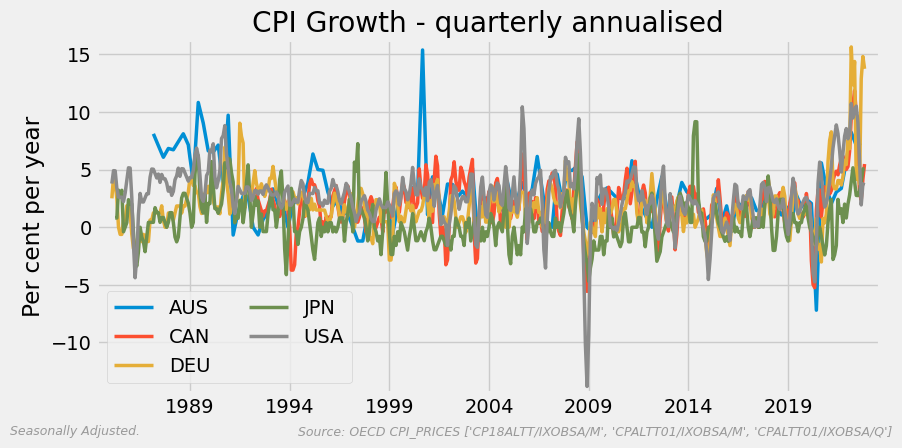

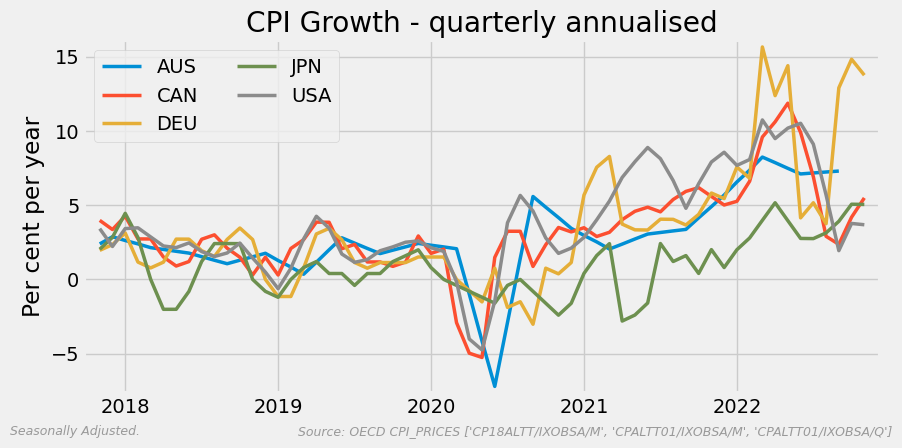

In [12]:
# plot 
title = 'CPI Growth - quarterly annualised'
for start in None, RECENT:
    data = annualised if start is None else annualised[annualised.index >= start]
    ax = data.plot(lw=2.5)
    ax.legend(title=None, loc='best', ncol=2)
    tag = "" if start is None else '-recent'

    finalise_plot(
        ax, title, 
        'Per cent per year', 
        tag, CHART_DIR,
        rfooter=f'{SOURCE} CPI_PRICES {series}',
        lfooter='Seasonally Adjusted.',
        show=True,
)

### Latest CPI components

In [13]:
locations = list(location_map.keys())
start = TODAY.year - 2
measure = 'IXOB'
components = {
    'all items': [
                  # subject, measure, frequency, start, gperiods, smoothing, annualised
                    ['CP18ALTT', measure, 'M', start, 12, 0, 0], # needed for Japan
                    ['CPALTT01', measure, 'M', start, 12, 0, 0],
                    ['CPALTT01', measure, 'Q', start, 4,  0, 0],
                ],
    'Food and non-alcoholic beverages': [
                  # subject, measure, frequency, start, gperiods, smoothing, annualised
                    ['CP180100', measure, 'M', start, 12, 0, 0], # needed for Japan
                    ['CP010000', measure, 'M', start, 12, 0, 0],
                    ['CP010000', measure, 'Q', start, 4,  0, 0],
                ],
    'Energy': [
                  # subject, measure, frequency, start, gperiods, smoothing, annualised
                    ['CP18GREN', measure, 'M', start, 12, 0, 0], # needed for Japan
                    ['CPGREN01', measure, 'M', start, 12, 0, 0],
                    ['CPGREN01', measure, 'Q', start, 4,  0, 0],
                ],
}

In [14]:
frame = pd.DataFrame()
get_data_date = lambda series: str(pd.Period(series.last_valid_index(), freq='M'))
loop_count = 0

for component, instructions in components.items():
    _, data = get_combine(locations, instructions) 
    latest = data.ffill().iloc[-1]

    if not loop_count:
        as_at = data.apply(get_data_date)
        latest = latest.sort_values()
    latest = latest.rename(location_map)
    
    # pop into the dataframe
    frame[component] = latest
    
    # wrap-up loop
    loop_count += 1

frame.head()

Check: did not capture ['ARG']
Check: did not capture ['ARG', 'BRA', 'IND', 'IDN']
Check: did not capture ['ARG', 'BRA', 'CHN', 'IND', 'IDN', 'RUS', 'SAU']


,all items,Food and non-alcoholic beverages,Energy
China (PRC),1.873789,4.269243,NaN
Switzerland,2.840271,4.039991,16.205581
Saudi Arabia,3.036294,4.260390,NaN
Japan,3.796136,7.128779,13.094187
Indonesia,4.820689,NaN,NaN


/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_79717/1426487999.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=90, )


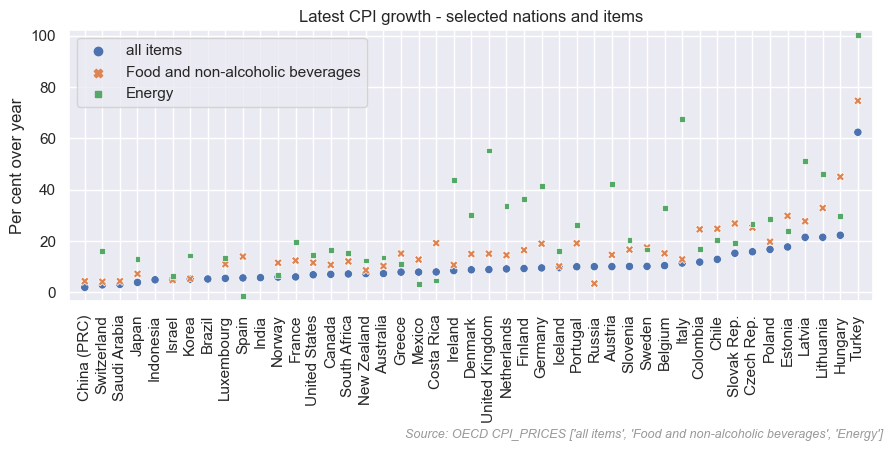

In [15]:
# ... and plot
sns.set(font_scale=1)
ax = sns.scatterplot(frame)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels=labels, rotation=90, )
ax.legend(loc='upper left')

finalise_plot(
    ax, 
    'Latest CPI growth - selected nations and items', 
    'Per cent over year', 
    '', CHART_DIR,
    rfooter=f'{SOURCE} CPI_PRICES {list(components.keys())}',
    show=True,
)